# Pneumonia X-Ray detection

## Import Libraries

In [1]:
import os
from pathlib import Path
import numpy as np
import pandas as pd
from PIL import Image
from matplotlib import pyplot as plt

## Download pneumonia dataset

The dataset will be placed in the `dataset` folder, with the following tree structure:
```
├── dataset
│   └── chest_xray
│       ├── chest_xray
│       │   ├── test
│       │   │   ├── NORMAL
│       │   │   └── PNEUMONIA
│       │   ├── train
│       │   │   ├── NORMAL
│       │   │   └── PNEUMONIA
│       │   └── val
│       │       ├── NORMAL
│       │       └── PNEUMONIA
```

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Setup kaggle with kaggle.json in "MyDrive" ("Il Mio Drive") folder

# install the Kaggle library
!pip install kaggle

# make a directory named “.kaggle”
!mkdir ~/.kaggle

# copy the “kaggle.json” into this new directory
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json

# allocate the required permission for this file
!chmod 600 ~/.kaggle/kaggle.json

# download pneumonia dataset
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

# unzip it into dataset folder
!mkdir dataset
!unzip chest-xray-pneumonia.zip -d dataset


## Import and explore data

In [3]:
print("importing dataset...")

data_dir = Path('dataset/chest_xray/chest_xray')
train_dir = data_dir/'train'
val_dir = data_dir/'val'
test_dir = data_dir/'test'

def load_set_from_dir(base_dir: Path):
  normal_dir = base_dir / 'NORMAL'
  normal_cases = normal_dir.glob('*.jpeg')
  pneumonia_dir = base_dir / 'PNEUMONIA'
  pneumonia_cases = pneumonia_dir.glob('*.jpeg')

  data = []
  label = []
  
  for sample in normal_cases:
    data.append(sample)
    label.append('NORMAL')
  for sample in pneumonia_cases:
    data.append(sample)
    label.append('PNEUMONIA')
  
  df = pd.DataFrame(data)
  df.rename(columns = {0 : 'image'}, inplace=True)  
  df['label'] = label

  # shuffle the data
  df = df.sample(frac=1).reset_index(drop=True)

  return df

print("loading train...")
train_data = load_set_from_dir(train_dir)
print("loading validation...")
val_data = load_set_from_dir(val_dir)
print("loading test...")
test_data = load_set_from_dir(test_dir)
print("\neverything loaded.")


importing dataset...
loading train...
loading validation...
loading test...

everything loaded.


In [4]:
# explore the data

print('train data infos:\n')
# print(train_data.info())
# print()
print(train_data['label'].value_counts())
print("""
!!!
This doesn’t look good, our trainig data is imbalanced. 
The number of images containing pneumonia is three times the number of normal images. 
Honestly, this is a fundamental problem with most medical datasets out there, 
as the people who go to a doctor with an ailment mostly have one.
!!!
      """)
print()
print(train_data.head(3))
print('\n...')
print(train_data.tail(2))
print()


train data infos:

PNEUMONIA    3875
NORMAL       1341
Name: label, dtype: int64

!!!
This doesn’t look good, our trainig data is imbalanced. 
The number of images containing pneumonia is three times the number of normal images. 
Honestly, this is a fundamental problem with most medical datasets out there, 
as the people who go to a doctor with an ailment mostly have one.
!!!
      

                                               image      label
0  dataset/chest_xray/chest_xray/train/NORMAL/IM-...     NORMAL
1  dataset/chest_xray/chest_xray/train/PNEUMONIA/...  PNEUMONIA
2  dataset/chest_xray/chest_xray/train/PNEUMONIA/...  PNEUMONIA

...
                                                  image      label
5214  dataset/chest_xray/chest_xray/train/PNEUMONIA/...  PNEUMONIA
5215  dataset/chest_xray/chest_xray/train/PNEUMONIA/...  PNEUMONIA



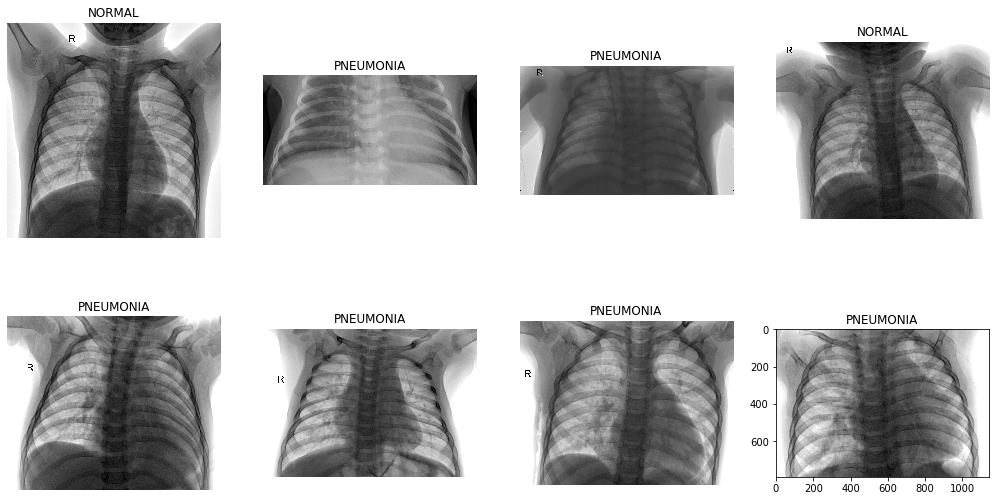

In [5]:
# display some sample images

n_rows = 2
n_cols = 4
plt.figure(figsize=(n_cols * 4.4, n_rows * 4.6))
for row in range(n_rows):
    for col in range(n_cols):
        position = n_cols * row + col
        plt.axis('off')
        plt.subplot(n_rows, n_cols, position + 1)
        image = plt.imread(train_data['image'].iloc[position])
        plt.imshow(image, cmap="binary", interpolation="nearest")
        title = train_data['label'].iloc[position]
        plt.title(title)
plt.show()


## Preprocessing

In [6]:
from sklearn.model_selection import train_test_split

In [7]:
#convert dataframes to numpy array
train_set = train_data.to_numpy()
val_set = val_data.to_numpy()
test_set = test_data.to_numpy()

In [8]:
#convert path object to images of a given dimension (HEIGHT, WIDTH)
#Split the dataset into X_set and y_set and returns them
def convert_dataset(data, dimension):
  image_data = []
  label_data = []
  labels = {'PNEUMONIA': 1, 'NORMAL': 0}
  for i in range(data.shape[0]):
    image = np.array(Image.open(str(data[i, 0])))
    image = np.resize(image, dimension)
    image = image.astype('float32')
    image /= 255
    image_data.append(image)
    label_data.append(labels[data[i, 1]])

  return np.array(image_data).astype('float32'), np.array(label_data).astype('uint8')

In [9]:
#specify image shape
height = 200
width = 200
dimension = (height, width)

#convert datasets into train_val and test
X_train_val, y_train_val = convert_dataset(train_set, dimension)
X_test, y_test = convert_dataset(test_set, dimension)

#since val_set has only 16 elements, extract it from train_val_set using sklearn function
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.05)

In [10]:
#number of samples in all the three sets
print('SIZES')
print('Training set: {}\nValidation set: {}\nTest set: {}'.format(X_train.shape[0], X_val.shape[0], X_test.shape[0]))

SIZES
Training set: 4955
Validation set: 261
Test set: 624


Input normalization

In [11]:
#mean and std
mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)

X_train = (X_train - mean) / std
X_val = (X_val - mean) / std
X_test = (X_test - mean) / std

Datasets for 3 channels images

In [12]:
#expand dimension to 3
rgb_train = np.expand_dims(X_train, 3)
rgb_val = np.expand_dims(X_val, 3)
rgb_test = np.expand_dims(X_test, 3)

#duplicate last value for red, green and blue
rgb_train = np.broadcast_to(rgb_train, (rgb_train.shape[0], rgb_train.shape[1], rgb_train.shape[2], 3)).copy()
rgb_val = np.broadcast_to(rgb_val, (rgb_val.shape[0], rgb_val.shape[1], rgb_val.shape[2], 3)).copy()
rgb_test = np.broadcast_to(rgb_test, (rgb_test.shape[0], rgb_test.shape[1], rgb_test.shape[2], 3)).copy()

## Models definition

In [13]:
import tensorflow as tf
from tensorflow import keras

In [14]:
#add 1 dimension to the image shape
input_shape = (height, width, 1)
#add 3 for rgb images
rgb_shape = (height, width, 3)

### Basic Model
Simple CNN with a convolutional layer, a maxpool layer, a dense layer of 100 neurons and a single terminal neuron

In [46]:
#model definition
basic_model = tf.keras.Sequential([
              tf.keras.layers.InputLayer(input_shape=input_shape),
              #tf.keras.layers.RandomCrop(145, 145),
              #tf.keras.layers.RandomFlip("horizontal_and_vertical"),
              #tf.keras.layers.RandomTranslation(0.2, 0.2, "reflect"),
              #tf.keras.layers.RandomRotation(0.2),
              #tf.keras.layers.RandomContrast(0.2),
              tf.keras.layers.Conv2D(filters=32, kernel_size=(5, 5), activation='relu'),
              tf.keras.layers.MaxPool2D(pool_size=(5, 5)),
              tf.keras.layers.Flatten(),
              tf.keras.layers.Dense(100, activation='relu'),
              tf.keras.layers.Dense(1, activation='sigmoid')
])

#compile model
basic_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

#print model
basic_model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 196, 196, 32)      832       
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 39, 39, 32)       0         
 g2D)                                                            
                                                                 
 flatten_15 (Flatten)        (None, 48672)             0         
                                                                 
 dense_31 (Dense)            (None, 100)               4867300   
                                                                 
 dense_32 (Dense)            (None, 1)                 101       
                                                                 
Total params: 4,868,233
Trainable params: 4,868,233
Non-trainable params: 0
___________________________________________

### Improved Model
A better model which inludes a convolutional and maxpool layer more, in addition to Dropout regularization

In [47]:
#model definition
improved_model = tf.keras.Sequential([
              tf.keras.layers.InputLayer(input_shape=input_shape),
              tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
              tf.keras.layers.MaxPool2D(pool_size=(3, 3)),
              tf.keras.layers.Dropout(rate=0.4),
              tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu'),
              tf.keras.layers.MaxPool2D(pool_size=(3, 3)),
              tf.keras.layers.Dropout(rate=0.4),
              tf.keras.layers.Flatten(),
              tf.keras.layers.Dense(100, activation='relu'),
              tf.keras.layers.Dropout(rate=0.4),
              tf.keras.layers.Dense(1, activation='sigmoid')
])

#compile model
improved_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

#print model
improved_model.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_25 (Conv2D)          (None, 198, 198, 64)      640       
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 66, 66, 64)       0         
 g2D)                                                            
                                                                 
 dropout_11 (Dropout)        (None, 66, 66, 64)        0         
                                                                 
 conv2d_26 (Conv2D)          (None, 64, 64, 32)        18464     
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, 21, 21, 32)       0         
 g2D)                                                            
                                                                 
 dropout_12 (Dropout)        (None, 21, 21, 32)      

### Our Best Model
This is the best model we create

In [48]:
#model definition
best_model = tf.keras.Sequential([
              tf.keras.layers.InputLayer(input_shape=input_shape),
              tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'),
              tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
              tf.keras.layers.MaxPool2D(pool_size=(3, 3)),
              tf.keras.layers.Dropout(rate=0.4),
              tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'),
              tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
              tf.keras.layers.MaxPool2D(pool_size=(3, 3)),
              tf.keras.layers.Dropout(rate=0.4),
              tf.keras.layers.Flatten(),
              tf.keras.layers.Dense(100, activation='relu'),
              tf.keras.layers.Dropout(rate=0.4),
              tf.keras.layers.Dense(1, activation='sigmoid')
])

#compile model
best_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

#print model
best_model.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_27 (Conv2D)          (None, 200, 200, 128)     1280      
                                                                 
 conv2d_28 (Conv2D)          (None, 198, 198, 128)     147584    
                                                                 
 max_pooling2d_23 (MaxPoolin  (None, 66, 66, 128)      0         
 g2D)                                                            
                                                                 
 dropout_14 (Dropout)        (None, 66, 66, 128)       0         
                                                                 
 conv2d_29 (Conv2D)          (None, 66, 66, 64)        73792     
                                                                 
 conv2d_30 (Conv2D)          (None, 64, 64, 64)        36928     
                                                     

### AlexNet implementation

In [49]:
alexnet = tf.keras.Sequential([
          tf.keras.layers.InputLayer(input_shape=input_shape),
          tf.keras.layers.Conv2D(filters=96, kernel_size=(11, 11), strides=(4, 4), activation='relu'),
          tf.keras.layers.MaxPool2D(pool_size=(3, 3), strides=(2, 2)),
          tf.keras.layers.Conv2D(filters=256, kernel_size=(5, 5), padding='same', activation='relu'),
          tf.keras.layers.MaxPool2D(pool_size=(3, 3), strides=(2, 2)),
          tf.keras.layers.Conv2D(filters=384, kernel_size=(3, 3), padding='same', activation='relu'),
          tf.keras.layers.Conv2D(filters=384, kernel_size=(3, 3), padding='same', activation='relu'),
          tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), padding='same', activation='relu'),
          tf.keras.layers.MaxPool2D(pool_size=(3, 3), strides=(2, 2)),
          tf.keras.layers.Flatten(),
          tf.keras.layers.Dropout(rate=0.5),
          tf.keras.layers.Dense(4096, activation='relu'),
          tf.keras.layers.Dropout(rate=0.5),
          tf.keras.layers.Dense(1000, activation='relu'),
          tf.keras.layers.Dense(1, activation='sigmoid')
])

#compile model
alexnet.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

#print model
alexnet.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_31 (Conv2D)          (None, 48, 48, 96)        11712     
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 23, 23, 96)       0         
 g2D)                                                            
                                                                 
 conv2d_32 (Conv2D)          (None, 23, 23, 256)       614656    
                                                                 
 max_pooling2d_26 (MaxPoolin  (None, 11, 11, 256)      0         
 g2D)                                                            
                                                                 
 conv2d_33 (Conv2D)          (None, 11, 11, 384)       885120    
                                                                 
 conv2d_34 (Conv2D)          (None, 11, 11, 384)     

### Tensorflow Model

In [ ]:
#use a model available in tensorflow only for 3 channels images

## Training

In [63]:
pneumonia_tot = train_data['label'].value_counts()[0] + val_data['label'].value_counts()[0] + test_data['label'].value_counts()[0]
normal_tot = train_data['label'].value_counts()[1] + val_data['label'].value_counts()[1] + test_data['label'].value_counts()[1]
total = pneumonia_tot + normal_tot
total_training = train_data['label'].value_counts()[0] + train_data['label'].value_counts()[1]

weight_for_pneumonia = (1 / pneumonia_tot) * (total_training / 2.0)
weight_for_normal = (1 / normal_tot) * (total_training / 2.0)
print(weight_for_pneumonia)
print(weight_for_normal)

#setting weights for focusing the training phase on the least represented class of images 
class_weight = {0: weight_for_normal, 1: weight_for_pneumonia}

0.6103440205944302
1.647504737839545


Basic Model training

In [64]:
basic_history = basic_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val), class_weight=class_weight)

Epoch 1/50
155/155 [==============================] - 10s 60ms/step - loss: 0.0018 - accuracy: 0.9994 - val_loss: 0.5289 - val_accuracy: 0.9310
Epoch 2/50
155/155 [==============================] - 10s 68ms/step - loss: 0.0021 - accuracy: 0.9992 - val_loss: 0.5656 - val_accuracy: 0.9272
Epoch 3/50
155/155 [==============================] - 7s 43ms/step - loss: 0.0019 - accuracy: 0.9996 - val_loss: 0.5543 - val_accuracy: 0.9195
Epoch 4/50
155/155 [==============================] - 5s 30ms/step - loss: 0.0021 - accuracy: 0.9990 - val_loss: 0.6516 - val_accuracy: 0.9119
Epoch 5/50
155/155 [==============================] - 5s 30ms/step - loss: 0.0814 - accuracy: 0.9740 - val_loss: 0.4684 - val_accuracy: 0.9080
Epoch 6/50
155/155 [==============================] - 5s 30ms/step - loss: 0.0278 - accuracy: 0.9899 - val_loss: 0.4479 - val_accuracy: 0.9272
Epoch 7/50
155/155 [==============================] - 5s 33ms/step - loss: 0.0155 - accuracy: 0.9946 - val_loss: 0.4612 - val_accuracy: 0.90

In [65]:
print('Basic Model:\n')
scores = basic_model.evaluate(X_test, y_test, verbose=2)
print(" %s: %.2f%%" % (basic_model.metrics_names[1], scores[1]*100))
print("----------------------------")


Basic Model:

20/20 - 0s - loss: 4.3476 - accuracy: 0.7436 - 274ms/epoch - 14ms/step
 accuracy: 74.36%
----------------------------


In [66]:
improved_history = improved_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val), class_weight=class_weight)

Epoch 1/50
155/155 [==============================] - 11s 70ms/step - loss: 0.0439 - accuracy: 0.9847 - val_loss: 0.3365 - val_accuracy: 0.9234
Epoch 2/50
155/155 [==============================] - 11s 69ms/step - loss: 0.0455 - accuracy: 0.9847 - val_loss: 0.3892 - val_accuracy: 0.9195
Epoch 3/50
155/155 [==============================] - 11s 70ms/step - loss: 0.0367 - accuracy: 0.9859 - val_loss: 0.3248 - val_accuracy: 0.9234
Epoch 4/50
155/155 [==============================] - 11s 70ms/step - loss: 0.0334 - accuracy: 0.9871 - val_loss: 0.4052 - val_accuracy: 0.9080
Epoch 5/50
155/155 [==============================] - 11s 70ms/step - loss: 0.0409 - accuracy: 0.9837 - val_loss: 0.3547 - val_accuracy: 0.9234
Epoch 6/50
155/155 [==============================] - 11s 69ms/step - loss: 0.0314 - accuracy: 0.9869 - val_loss: 0.4041 - val_accuracy: 0.9119
Epoch 7/50
155/155 [==============================] - 11s 69ms/step - loss: 0.0419 - accuracy: 0.9839 - val_loss: 0.4614 - val_accuracy:

In [67]:
print('Improved Model:\n')
scores = improved_model.evaluate(X_test, y_test, verbose=2)
print(" %s: %.2f%%" % (improved_model.metrics_names[1], scores[1]*100))
print("----------------------------")

Improved Model:

20/20 - 1s - loss: 7.2207 - accuracy: 0.7179 - 617ms/epoch - 31ms/step
 accuracy: 71.79%
----------------------------


In [68]:
best_history = best_model.fit(X_train, y_train, epochs=15, batch_size=32, validation_data=(X_val, y_val), class_weight=class_weight)

Epoch 1/15
155/155 [==============================] - 97s 625ms/step - loss: 0.1319 - accuracy: 0.9461 - val_loss: 0.1995 - val_accuracy: 0.9119
Epoch 2/15
155/155 [==============================] - 97s 624ms/step - loss: 0.1079 - accuracy: 0.9510 - val_loss: 0.2017 - val_accuracy: 0.9272
Epoch 3/15
155/155 [==============================] - 97s 623ms/step - loss: 0.0996 - accuracy: 0.9546 - val_loss: 0.3015 - val_accuracy: 0.9080
Epoch 4/15
155/155 [==============================] - 96s 622ms/step - loss: 0.0945 - accuracy: 0.9558 - val_loss: 0.2070 - val_accuracy: 0.9310
Epoch 5/15
155/155 [==============================] - 97s 624ms/step - loss: 0.0894 - accuracy: 0.9574 - val_loss: 0.2365 - val_accuracy: 0.9272
Epoch 6/15
155/155 [==============================] - 97s 623ms/step - loss: 0.0788 - accuracy: 0.9655 - val_loss: 0.2197 - val_accuracy: 0.9310
Epoch 7/15
155/155 [==============================] - 97s 624ms/step - loss: 0.0802 - accuracy: 0.9657 - val_loss: 0.2834 - val_ac

In [69]:
print('Best Model:\n')
scores = best_model.evaluate(X_test, y_test, verbose=2)
print(" %s: %.2f%%" % (best_model.metrics_names[1], scores[1]*100))
print("----------------------------")

Best Model:

20/20 - 3s - loss: 3.9403 - accuracy: 0.7676 - 3s/epoch - 165ms/step
 accuracy: 76.76%
----------------------------


In [ ]:
alexnet_history = alexnet.fit(X_train, y_train, epochs=150, batch_size=32, validation_data=(X_val, y_val), class_weight=class_weight)

In [ ]:
print('AlexNet:\n')
scores = alexnet.evaluate(X_test, y_test, verbose=2)
print(" %s: %.2f%%" % (alexnet.metrics_names[1], scores[1]*100))
print("----------------------------")

## Performace

In [70]:
def plot_loss(history):
  plt.figure(figsize=(10,6))
  plt.plot(history.epoch,history.history['loss'], label='loss')
  plt.plot(history.epoch,history.history['val_loss'],label='val_loss')
  plt.title('loss')
  plt.legend()
  
def plot_accuracy(history):
  plt.figure(figsize=(10,6))
  plt.plot(history.epoch,history.history['accuracy'],label='accuracy')
  plt.plot(history.epoch,history.history['val_accuracy'],label='val_accuracy')
  plt.title('accuracy')
  plt.legend()

### Basic Model Plot

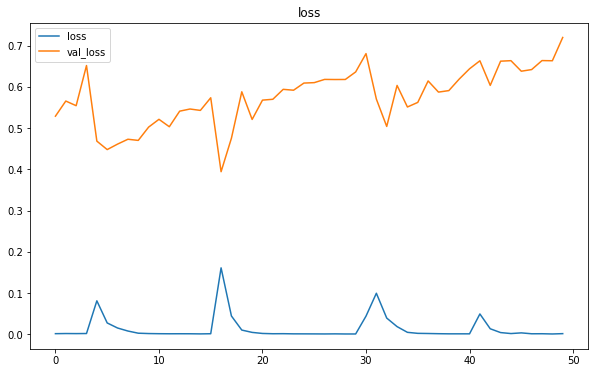

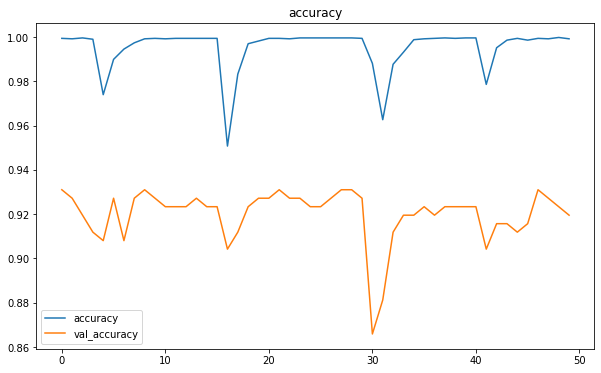

In [71]:
plot_loss(basic_history)
plot_accuracy(basic_history)

### Improved Model Plot

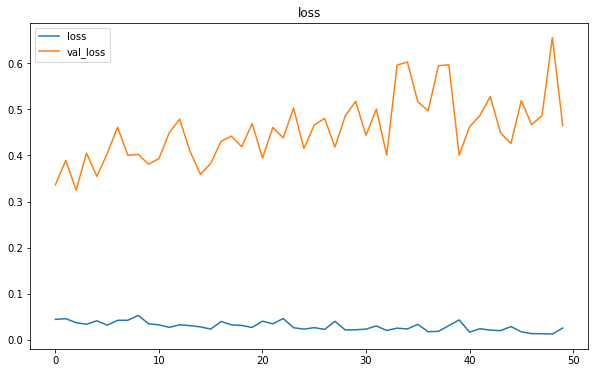

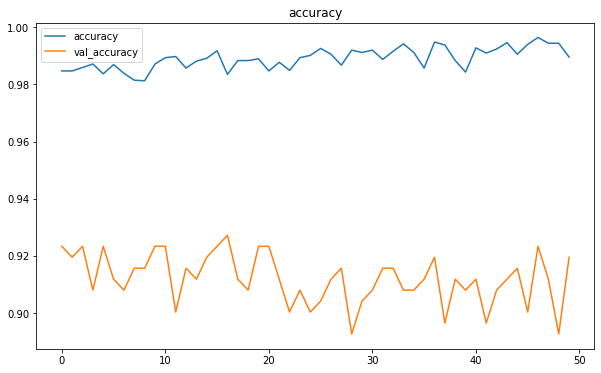

In [72]:
plot_loss(improved_history)
plot_accuracy(improved_history)

### Best Model Plot

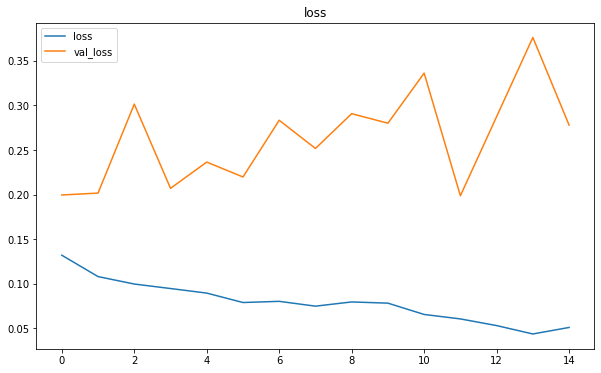

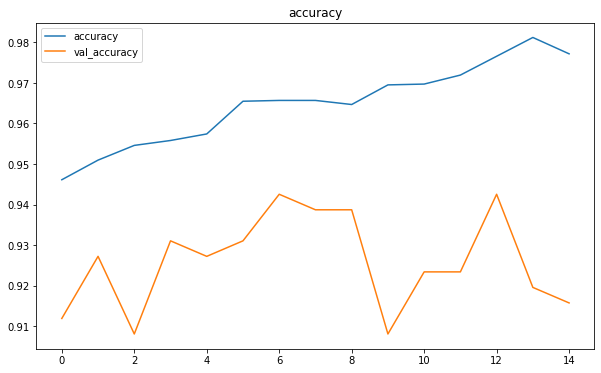

In [73]:
plot_loss(best_history)
plot_accuracy(best_history)

## Model evaluation

In [74]:
print('Basic Model:\n')
scores = basic_model.evaluate(X_test, y_test, verbose=2)
print(" %s: %.2f%%" % (basic_model.metrics_names[1], scores[1]*100))
print("----------------------------")

print('Improved Model:\n')
scores = improved_model.evaluate(X_test, y_test, verbose=2)
print(" %s: %.2f%%" % (improved_model.metrics_names[1], scores[1]*100))
print("----------------------------")

print('Best Model:\n')
scores = best_model.evaluate(X_test, y_test, verbose=2)
print(" %s: %.2f%%" % (best_model.metrics_names[1], scores[1]*100))
print("----------------------------")

Basic Model:

20/20 - 0s - loss: 4.3476 - accuracy: 0.7436 - 326ms/epoch - 16ms/step
 accuracy: 74.36%
----------------------------
Improved Model:

20/20 - 1s - loss: 7.2207 - accuracy: 0.7179 - 540ms/epoch - 27ms/step
 accuracy: 71.79%
----------------------------
Best Model:

20/20 - 3s - loss: 3.9403 - accuracy: 0.7676 - 3s/epoch - 161ms/step
 accuracy: 76.76%
----------------------------
